<h1><font color="#113D68" size=6>Improving Deep Learning by Exploiting Synthetic Images</font></h1>

<h1><font color="#113D68" size=5>Part 2. Vision Transformers (ViT)</font></h1>

<h1><font color="#113D68" size=4>Self-Attentio Block</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo Cara</font><br>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Licencia</font></h2>

<p><small><small>Improving Deep Learning by Exploiting Synthetic Images Copyright 2024 Manuel Castillo Cara.</p>
<p><small><small> Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at </p>
<p><small><small> <a href="https://www.apache.org/licenses/LICENSE-2.0">https://www.apache.org/licenses/LICENSE-2.0</a> </p>
<p><small><small> Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. </p>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
El código de este tutorial ha sido sacado del [GitHub minGPT](https://github.com/karpathy/minGPT/blob/master/mingpt/model.py)

---

<a id="indice"></a>
<h2><font color="#004D7F" size=6>Índice</font></h2>

* [1. Definición, fortalezas y debilidades](#section1)
    * [1.1. Self-Attention en Vision Transformer (ViT)](#section12)
    * [1.2. Componentes en Self-Attention](#section12)
    * [1.3. Fortalezas y Debilidades](#section13)
* [2. Dataset](#section2)
* [3. Multilayer Perceptron](#section3)
* [4. El Modelo Self-Attention](#section4)
    * [4.1. Módulo self-attention](#section41)
    * [4.2. Atención escalada de productos](#section42)
    * [4.3. Clasicador MLP](#section43)
* [5. Entrenamiento y evaluación del modelo](#section5)
---

<a id="section1"></a>
# <font color="#004D7F" size=6> 1. Definición, fortalezas y debilidades</font>

Los Vision Transformer (ViT) son una adaptación del modelo Transformer, originalmente diseñado para tareas de procesamiento de lenguaje natural, aplicado a tareas de visión por computadora. En lugar de procesar secuencias de palabras, los ViT dividen una imagen en **patchs** y procesan estos patchs como **secuencias de tokens**. Al hacerlo, pueden capturar dependencias globales entre los patchs de la imagen y han demostrado ser eficaces en tareas como la clasificación de imágenes, la detección de objetos y más.

<figure><center>
  <img src="../img/vit.png" width="450" height="250" alt="Gráfica">
  <figcaption><blockquote>Arquitectura de ViT y del Trasformer Encoder. Extraída de <a href="https://arxiv.org/abs/2010.11929">artículo de ViT</a></blockquote></figcaption>
</center></figure>

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Más información se recomienda la lectura del artículo [ViT](https://arxiv.org/abs/2010.11929)

<a id="section11"></a>
# <font color="#004D7F" size=5> 1.1. Self-Attention en Vision Transformer (ViT)</font>

El módulo de Self-attention es un componente clave en la arquitectura de los modelos Transformer, que se utiliza en tareas de procesamiento de lenguaje natural y clasificación de imágenes. La idea básica detrás de Self-attention es permitir que el modelo aprenda a prestar atención a diferentes partes de la entrada al generar una representación de salida.

En el contexto de la clasificación de imágenes, Self-attention se utiliza para permitir que el modelo preste atención a diferentes partes de la imagen al generar una representación de la misma. Esto se logra mediante la aplicación de una función de atención a la entrada, que calcula los pesos de atención para cada par de elementos de entrada y luego utiliza estos pesos para generar una representación ponderada de la entrada.

La función de atención en Self-attention se define típicamente como una combinación lineal de tres matrices de entrada: 
- **Una matriz de consulta (*Q*)**: La matriz de consulta se utiliza para calcular los pesos de atención.
- **Una matriz de clave (*K*)** y **una matriz de valor (*V*)**: las matrices de clave y valor se utilizan para generar la representación ponderada de la entrada.

En resumen, Self-attention es un mecanismo de atención que permite que el modelo aprenda a prestar atención a diferentes partes de la entrada al generar una representación de la misma.

<a id="section12"></a>
# <font color="#004D7F" size=5> 1.2. Componentes en Self-Attention</font>

En el artículo [*Attention is all you need*](https://arxiv.org/abs/1706.03762) vemos que los autores indican que el mecanismo de atención elegido para su nueva arquitectura es el *scaled dot-product attention*.

<figure><center>
  <img src="../img/selfattention.png" width="250" height="300" alt="Gráfica">
  <figcaption><blockquote>Arquitectura self-attention. Extraída de <a href="https://arxiv.org/abs/1706.03762">Attention Is All You Need</a></blockquote></figcaption>
</center></figure>

Este mecanismo de atención consiste en tres conjuntos de vectores $K$, $Q$ y $V$, llamados respectivamente *keys*, *queries* y *values*. Utilizaremos $K$ y $Q$ para calcular la matriz de atención, la cual aplicaremos a $V$.

$$Attention(Q,K,V)= softmax(\frac{Q K^T}{\sqrt{d_k}}) V$$

En este caso escalamos el producto de $Q$ y $K$ con la raíz cuadrada de su dimensión, $d_k$. ¿De dónde vienen estas $Q$, $K$ y $V$? 
 - Aquí es donde entra en juego la componente de aprendizaje. Al tener una activación softmax nuestro "MLP" podrá cambiar los pesos cada vez que cambie la entrada, i.e., se ajusta a la entrada los vectores input en ese instante. Tenemos una arquitectura mucho más flexible porque no tenemos un conjunto de pesos fijo como en el MLP.
 - Para que este sistema sea capaz de aprender, calcularemos los diferentes vectores utilizando perceptrones: $Q = W_q X$, $K = W_k X$  y $V = W_v X$. Incido, la importancia de los pesos para cada vector.
 - De esta manera, nuestro sistema será capaz de calcular la mejor representación de $X$ para obtener un alineamiento óptimo en el mecanismo de atención.
 - 💡 **Importante**: Vemos que al igual que las CNN, los pesos se comparte para todo Q, K y V. Y, ¡no solo eso! A grandes rasgos, puedes entender el mecanismo de atención como un perceptrón cuyos pesos dependen de los datos de entrada, en vez de ser siempre los mismos (resultado del entrenamiento).
 - El mecanismo de atención implementado reutiliza pesos para cada *patch*, similar a una CNN. Sin embargo, solo vamos a utilizar un conjunto de pesos, en una CNN equivaldría a un solo *kernel* o filtro. Para mejorar la capacidad de representación de una CNN, necesitamos usar muchos filtros. El equivalente a este concepto en los *Transofrmers* se conoce como *Multi-head attention*, que será la siguiente práctica.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Más información se recomienda la lectura del artículo [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

<a id="section13"></a>
# <font color="#004D7F" size=5> 1.3. Fortalezas y debilidades</font>

Fortalezas de Self-attention en ViT:

1. **Capacidad para modelar dependencias de largo alcance**: Self-attention permite que el modelo preste atención a cualquier parte de la entrada, lo que le permite modelar dependencias de largo alcance entre los píxeles de la imagen.
2. **Invariancia a la translación**: A diferencia de las capas de convolución, Self-attention no tiene una estructura espacial fija, lo que significa que es invariante a la translación. Esto es útil en tareas de clasificación de imágenes, donde la posición espacial de un objeto en la imagen puede ser irrelevante para la tarea.
3. **Capacidad para aprender representaciones de objetos completos**: Self-attention puede aprender a prestar atención a grupos de píxeles que forman objetos completos en la imagen, lo que puede mejorar la capacidad del modelo para clasificar correctamente las imágenes.

Debilidades de Self-attention en ViT:

1. **Alto costo computacional**: Self-attention tiene un costo computacional cuadrático con respecto a la longitud de la entrada, lo que puede ser un problema en tareas de clasificación de imágenes, donde la entrada puede ser muy grande.
2. **Dificultad para modelar dependencias locales**: Aunque Self-attention es bueno para modelar dependencias de largo alcance, puede tener dificultades para modelar dependencias locales entre los píxeles de la imagen. Esto puede ser un problema en tareas de clasificación de imágenes, donde la textura y el patrón local de los píxeles pueden ser importantes para la tarea.
3. **Necesidad de una gran cantidad de datos de entrenamiento**: Self-attention tiene una gran cantidad de parámetros que necesitan ser entrenados, lo que significa que el modelo puede requerir una gran cantidad de datos de entrenamiento para generalizar adecuadamente a nuevas imágenes.

<a id="section2"></a>
# <font color="#004D7F" size=6> 2. Dataset</font>

Cuando se preparan las imágenes para ser procesadas por un modelo de ViT, se dividen en múltiples patchs o *"tiles"* más pequeños. Este proceso se conoce como *"tiling"*. Cada patch se trata como un token independiente y se procesa como una secuencia de tokens, al igual que las palabras en una secuencia de texto.

Para realizar el *tiling*, se utiliza una capa convolucional. La capa convolucional se aplica directamente a la imagen de entrada y divide la imagen en patchs de un tamaño fijo, e.g., $16 \times 16$ píxeles. La capa convolucional también se utiliza para reproyectar los patchs en un espacio de dimensiones más bajo, lo que reduce la dimensionalidad de los datos y facilita el procesamiento posterior.

Una vez que se han dividido las imágenes en patchs y se han reproyectado en un espacio de dimensiones más bajo, se pueden procesar como secuencias de tokens y alimentar al modelo de Transformer. A nivel de conjunto de datos, simplemente se devuelven las imágenes y las etiquetas como de costumbre, sin necesidad de realizar ninguna preparación adicional de los datos.

In [1]:
import os
import math
import random
import tensorflow as tf
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# SET RANDOM SEED FOR REPRODUCIBILITY
SEED = 420
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

torch.device("mps")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

/Users/manwest/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


mps


La clase `Dataset` es una clase personalizada que hereda de la clase `torch.utils.data.Dataset` de PyTorch. 
- Esta clase se utiliza para cargar y procesar los datos de entrada y etiquetas correspondientes.
- La clase tiene un constructor que toma dos argumentos: `X` e `y`, que representan los datos de entrada y las etiquetas, respectivamente. 
- El método `__len__` devuelve la longitud del conjunto de datos, mientras que el método `__getitem__` devuelve un tensor de PyTorch para los datos de entrada y las etiquetas correspondientes.

In [2]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y.astype(int)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X.iloc[ix]).float(), torch.tensor(self.y.iloc[ix]).long()


La clase `MNISTDataModule` es una clase que hereda de la clase `pl.LightningDataModule` de PyTorch Lightning. 
- Carga y procesa los datos de entrenamiento y validación del conjunto de datos MNIST. 
- El argumento `batch_size` se utiliza para especificar el tamaño del lote de datos, mientras que el argumento `Dataset` se utiliza para especificar la clase de conjunto de datos personalizada que se utilizará para cargar y procesar los datos. 
- El método `setup` se utiliza para cargar y procesar los datos de entrenamiento y validación del conjunto de datos MNIST. 
- El método `train_dataloader` se utiliza para crear un cargador de datos para los datos de entrenamiento.
- El método `val_dataloader` se utiliza para crear un cargador de datos para los datos de validación. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
💡 **Importante**: Para fines prácticos y acelerar el proceso de aprendizaje en vez de 60000 imágenes pon otro número que se adapte a tu máquina.

In [ ]:
class MNISTDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset

    def setup(self, stage=None):
        mnist = fetch_openml('mnist_784', version=1)
        X, y = mnist["data"], mnist["target"]
        X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., y[:60000].astype(int), y[60000:].astype(int)
        self.train_ds = self.Dataset(X_train, y_train)
        self.val_ds = self.Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

Tenemos imágenes de 28x28x1 por lo tanto vamos a estirarlo en un vector de tamaño 784 y trabajamos en un batch size de 64 imágenes.

In [3]:
dm = MNISTDataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_8392/2155512938.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.X.iloc[ix]).float(), torch.tensor(self.y.iloc[ix]).long()


(torch.Size([64, 784]), torch.Size([64]))

Procedemos a visualizar.

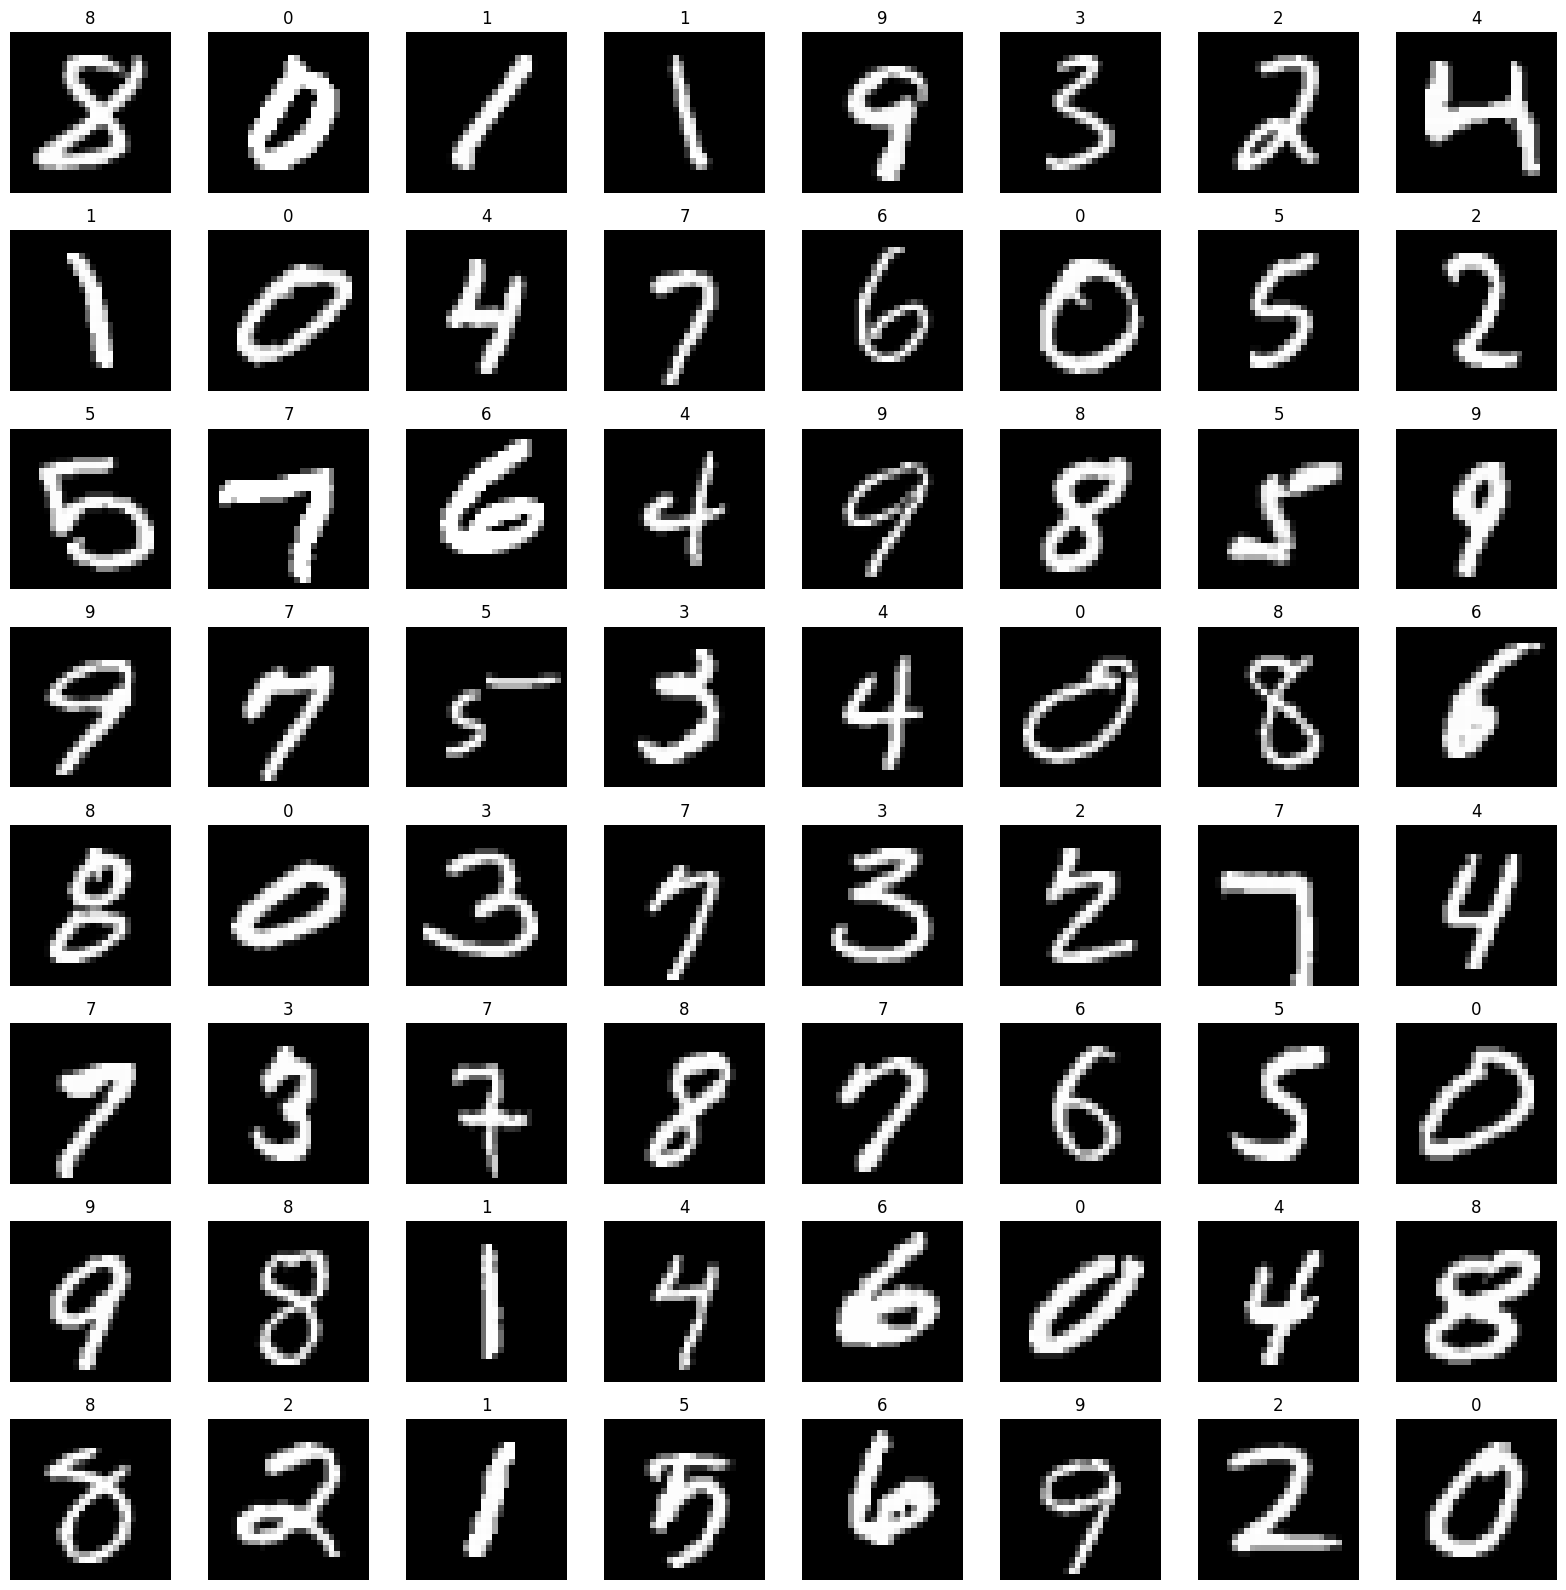

In [4]:
r, c = 8, 8
fig = plt.figure(figsize=(c*2, r*2))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(label.item())
plt.tight_layout()
plt.show()

<a id="section3"></a>
# <font color="#004D7F" size=6> 3. Multilayer Perceptron</font>

Vamos a crear un clasificador por dos motivos: (i) para obtener unos resultados de línea base; y (ii) Para integrarlo en el modelo de atención.

Este código define una clase `MLP` que hereda de `pl.LightningModule` de PyTorch Lightning. Esta clase define una red neuronal multicapa (MLP) básica para la clasificación de imágenes.

En el constructor de la clase, se define la red neuronal como una secuencia de capas utilizando `torch.nn.Sequential`. La red consta de dos capas lineales (`torch.nn.Linear`) con una capa de activación ReLU (`torch.nn.ReLU`) entre ellas. La entrada a la red es una imagen aplanada de 28x28 píxeles (784 en total), y la salida es un vector de probabilidades para cada una de las 10 clases de dígitos.

El método `forward` define el flujo de la red neuronal. La entrada se pasa a través de la red neuronal secuencial definida en el constructor, y se devuelve la salida.

En resumen, este código define una red neuronal multicapa básica para la clasificación de imágenes utilizando PyTorch Lightning. La clase `MLP` define la red neuronal, las pérdidas y métricas de evaluación, y los pasos de entrenamiento y validación. El optimizador también se define en la clase.

In [5]:
class MLP(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(784, 784),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(784, 10)
        )

    def forward(self, x):
        return self.mlp(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)

    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.003)
        return optimizer

Para nuestro caso, se pasa un tensor aleatorio de tamaño `(64, 784)` a la red `MLP`, donde `64` es el tamaño del lote y `784` son las características de entrada (imágenes aplanadas de 28x28 píxeles).
 
Así, verificamos el correcto funcionamiento de este primer modelo.

In [6]:
mlp = MLP()
outuput = mlp(torch.randn(64, 784)).to(device)
outuput.shape

torch.Size([64, 10])

Ejecutamos el modelo MLP.

In [7]:
mlp = MLP().to(device)
trainer = pl.Trainer(max_epochs=5, logger=None)
trainer.fit(mlp, dm)

[MacBook-Pro-de-Manu.local:08392] shmem: mmap: an error occurred while determining whether or not /var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T//ompi.MacBook-Pro-de-Manu.501/jf.0/2454192128/sm_segment.MacBook-Pro-de-Manu.501.92480000.0 could be created.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 623 K 
------------------------------------
623 K     Trainable params
0         Non-trainable params
623 K     Total params
2.493     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/manwest/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_8392/2155512938.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.X.iloc[ix]).float(), torch.tensor(self.y.iloc[ix]).long()


/Users/manwest/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 938/938 [04:37<00:00,  3.38it/s, v_num=13, acc=1.000, val_loss=0.0809, val_acc=0.980]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 938/938 [04:37<00:00,  3.38it/s, v_num=13, acc=1.000, val_loss=0.0809, val_acc=0.980]


Obtenemos una precisión en los datos de validación del 97%, aunque fijaros la gran cantidad de parámetros a entrenar para nuestro dataset.

/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_8392/2155512938.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.X.iloc[ix]).float(), torch.tensor(self.y.iloc[ix]).long()


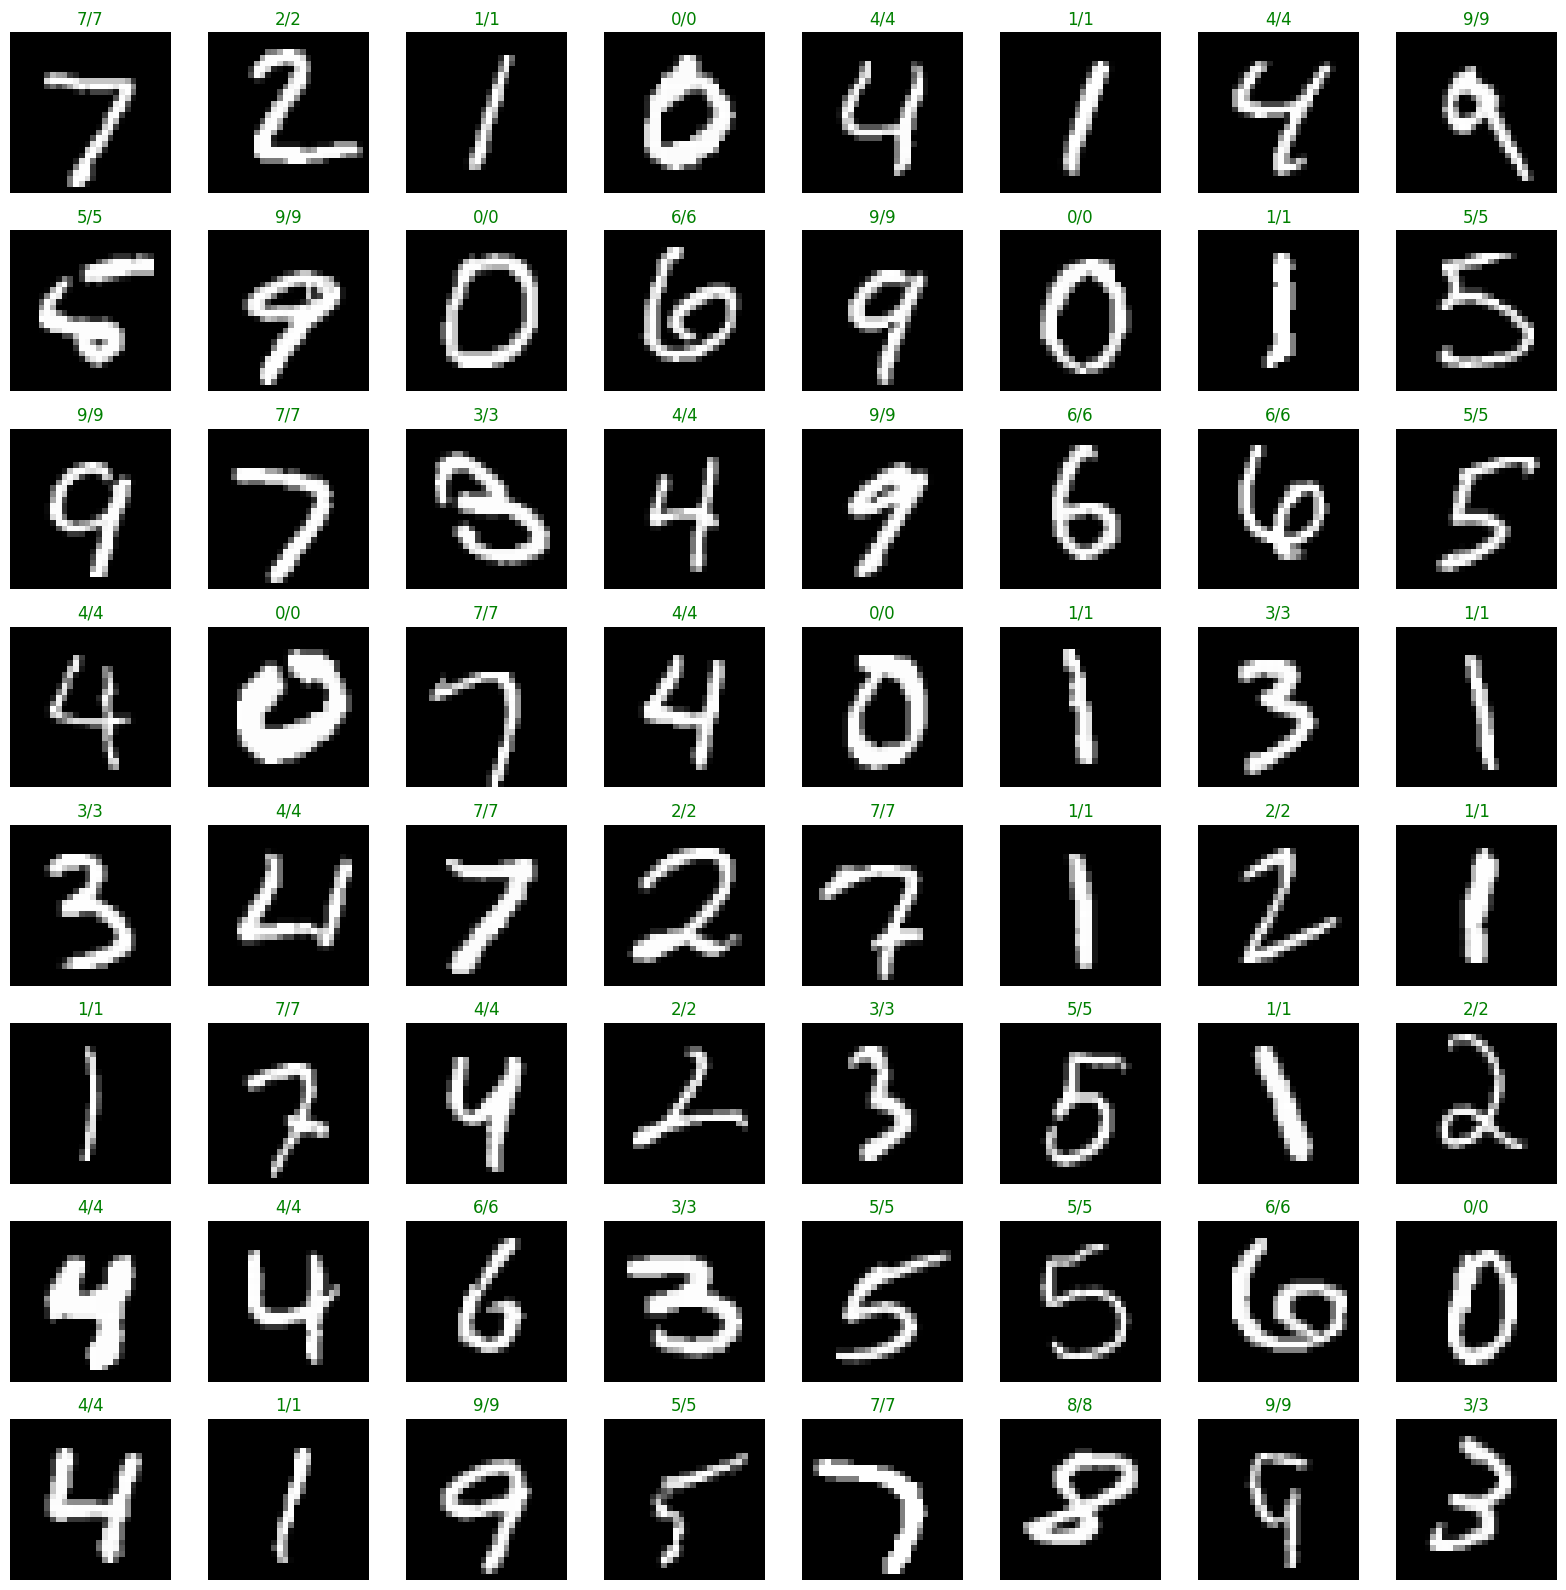

In [9]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = mlp.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(28,28), cmap="gray")
        ax.set_title(f'{label.item()}/{preds[ix].item()}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

<a id="section4"></a>
# <font color="#004D7F" size=6> 4. El Modelo Self-Attention</font>

Vamos ahora a resolver el problema utilizando el mecanismo de atención. Lo primero que tenemos que tener en cuenta es que los mecanismos de atención funcionan con conjuntos de vectores (secuencia), por lo que tenemos que reinterpretar nuestras imágenes. Para ello, vamos a dividirlas en 16 *patches* de 7x7. De esta manera, nuestras imágenes ahora serán secuencias de *patches* con las que nuestro mecanismo de atención podrá trabajar. 

**Importante**: 16x7x7 = 784 que es igual al tamaño total de píxeles de las imágenes donde 28x28=784.

<a id="section41"></a>
# <font color="#004D7F" size=5> 4.1. Módulo self-attention</font>

Este código define una clase `AttnDataset` que hereda de la clase `torch.utils.data.Dataset` y se utiliza para cargar y procesar los datos de entrada y etiquetas correspondientes para un modelo de atención.

La clase `AttnDataset` tiene un constructor que toma tres argumentos: 
- El argumento `X` representa los datos de entrada, 
- `y` representa las etiquetas correspondientes y 
- `patch_size` es el tamaño del parche que se utilizará para dividir las imágenes de entrada en parches más pequeños.
    - Tendremos 16 parches (4x4) ya que al divivir 28 (pixels de la imagen) entre 7 parches
    - Al aplanar cada parche a un vector tendríamos 49 valores (7x7 cada parche)

La clase tiene tres métodos especiales: 
- El método `__len__` devuelve la longitud del conjunto de datos, 
- El método `__getitem__` devuelve un elemento del conjunto de datos en el índice especificado. 
    - Además, divide la imagen de entrada en parches más pequeños utilizando la función `unfold` de PyTorch, aplana los parches en una sola fila y devuelve los parches y la etiqueta correspondiente como tensores.
 

Este enfoque de dividir las imágenes en parches más pequeños se utiliza comúnmente en ViT, ya que permite que el modelo preste atención a diferentes partes de la imagen de entrada y aprenda a combinar la información de estas partes para generar una representación más precisa de la imagen completa.

In [10]:
class AttnDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(7, 7)):
    self.X = X
    self.y = y
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.tensor(self.X.iloc[ix]).float().view(28, 28) # convertimos las imagenes en 28 x 28
    h, w = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w) # Hacemos los parches: 4 x 4 x 7 x 7
    patches = patches.contiguous().view(-1, h*w) # Aplanamos que serían 49 valores cada parche (en total 16 parches): 16 x 49
    return patches, torch.tensor(self.y.iloc[ix]).long()

In [12]:
attn_dm = MNISTDataModule(Dataset = AttnDataset)
attn_dm.setup()
imgs, labels = next(iter(attn_dm.train_dataloader()))
imgs.shape, labels.shape

/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_8392/2706106006.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = torch.tensor(self.X.iloc[ix]).float().view(28, 28) # 28 x 28


(torch.Size([64, 16, 49]), torch.Size([64]))

Veamos una muestra de cómo queda una imagen en patchs de 4x4

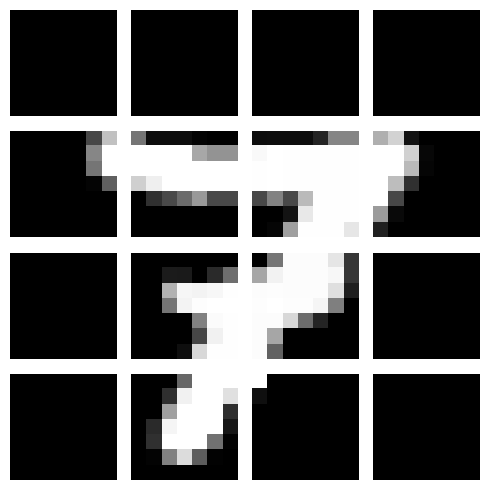

In [13]:
fig = plt.figure(figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, i*4 + j + 1)
        ax.imshow(imgs[6,i*4 + j].view(7, 7), cmap="gray")
        ax.axis('off')
plt.tight_layout()
plt.show()

<a id="section42"></a>
# <font color="#004D7F" size=5> 4.2. Atención escalada de productos</font>

La clase `ScaledDotSelfAttention` es una implementación de la atención escalada de productos, que es un mecanismo de atención utilizado en el modelo de Transformer. 
- La clase tiene un constructor que toma un argumento `n_embd`, que es el tamaño de embedding (dimensióm) de entrada.
- El constructor define tres capas lineales, `key`, `query` y `value`, que se utilizan para transformar la entrada en claves, consultas y valores, respectivamente.

El método `forward` toma una entrada de tamaño `(B, L, F)`, donde `B` es el tamaño del lote (64), `L` es la longitud de la secuencia (16 parches) y `F` es el numéro de features (embedding) que son 49 de la proyección de los parches 7x7 en vectores. 
- El método `forward` calcula las claves, consultas y valores aplicando las capas lineales correspondientes a la entrada (que son un MLP simple). 
- Luego, el método `forward` calcula la matriz de atención aplicando la fórmula de atención escalada de puntos, que es `(q @ k.transpose(1, 2)) * (1.0 / math.sqrt(k.size(-1)))`. 
- La matriz de atención se normaliza aplicando la función softmax y luego se utiliza para calcular la salida ponderada mediante la multiplicación de matrices con los valores.

 <figure><center>
  <img src="../img/selfattention3.png" width="350" height="200" alt="Gráfica">
  <figcaption><blockquote>Proyección de operaciones en self-attention. Extraída de <a href="https://medium.com/@saba99/self-attention-0b21baad0a48">Medium</a></blockquote></figcaption>
</center></figure>

In [14]:
class ScaledDotSelfAttention(torch.nn.Module):

    def __init__(self, n_embd):
        super().__init__()

        # Aquí es donde se aprende los pesos, es como si tuvieramos 3 MLP
        self.key = torch.nn.Linear(n_embd, n_embd)
        self.query = torch.nn.Linear(n_embd, n_embd)
        self.value = torch.nn.Linear(n_embd, n_embd)

    def forward(self, x):
        #`B` es el tamaño del lote (64), `L` es la longitud de la secuencia (16 parches) y 
        #`F` es el numéro de features (embedding) que son 49 píxeles.
        B, L, F = x.size()

        # calculate query, key, values
        # Reproyecta los vectores de entrada (x) a queries, keys y values
        k = self.key(x) # (B, L, F)
        q = self.query(x) # (B, L, F)
        v = self.value(x) # (B, L, F)

        # attention (B, L, F) x (B, F, L) -> (B, L, L)
        # El mecanismo de atención!!!
        att = (q @ k.transpose(1, 2)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, L, L) x (B, L, F) -> (B, L, F)

        return y

<a id="section43"></a>
# <font color="#004D7F" size=5> 4.3. Clasicador MLP</font>


La clase `Model` es una implementación de una red neuronal que utiliza la atención escalada de productos para clasificar imágenes. 
- La clase tiene un constructor que toma dos argumentos opcionales, `n_embd` y `seq_len`, que son el tamaño de embedding (49) de entrada y la longitud de la secuencia (4x4 = 16 parches en total), respectivamente. 
- El constructor define una capa de atención escalada de productos, una capa de activación ReLU y una capa lineal para la clasificación.

El método `forward` toma una entrada de tamaño `(B, L, F)`, donde `B` es el tamaño del lote, `L` es la longitud de la secuencia y `F` es el tamaño de embedding. 
- Aplica la capa de atención escalada de puntos a la entrada y luego aplica la capa de activación ReLU. 
- La salida se aplana mediante la función `view` y luego se aplica la capa lineal para la clasificación. 
- La salida final es una distribución de probabilidad sobre las 10 clases de MNIST.

In [15]:
class Model(MLP):

    def __init__(self, n_embd=7*7, seq_len=4*4):
        super().__init__()
        self.mlp = None
        # Lo único que haces es cambiar la primera capa del MLP anterior por el mecanismo de atención
        self.attn = ScaledDotSelfAttention(n_embd)
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(n_embd*seq_len, 10)

    def forward(self, x):
        x = self.attn(x)
        #print(x.shape)
        y = self.fc(self.actn(x.view(x.size(0), -1)))
        #print(y.shape)
        return y

<a id="section5"></a>
# <font color="#004D7F" size=6> 5. Entrenamiento y evaluación del modelo</font>

Nuestro modelo basado en atención tiene **muchos menos parámetros**. Esto es debido a que en el MLP todos las neuronas en la capa oculta están conectadas a todos los pixeles de la imagen. Ahora, sin embargo, reutilizamos conexiones a nivel de *patch*, de manera similar a cómo funcionan las redes convolucionales.

In [16]:
model = Model().to(device)
trainer = pl.Trainer(max_epochs=5, logger=None)
trainer.fit(model, attn_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type                   | Params
------------------------------------------------
0 | attn | ScaledDotSelfAttention | 7.4 K 
1 | actn | ReLU                   | 0     
2 | fc   | Linear                 | 7.9 K 
------------------------------------------------
15.2 K    Trainable params
0         Non-trainable params
15.2 K    Total params
0.061     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/manwest/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_8392/2706106006.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = torch.tensor(self.X.iloc[ix]).float().view(28, 28) # 28 x 28


/Users/manwest/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 938/938 [04:34<00:00,  3.42it/s, v_num=15, acc=0.969, val_loss=0.215, val_acc=0.937]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 938/938 [04:34<00:00,  3.42it/s, v_num=15, acc=0.969, val_loss=0.215, val_acc=0.937]


Obtenemos resultados similares, pero ligeramente inferiores. Esto es debido a que nuestro modelo tiene una menor capacidad de representación (menos parámetros). Sin embargo, obtenemos resultados notables.
Por supuesto, estos resultados pueden mejorarse configurando aún más el módulo de atención.

/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_8392/2706106006.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = torch.tensor(self.X.iloc[ix]).float().view(28, 28) # 28 x 28


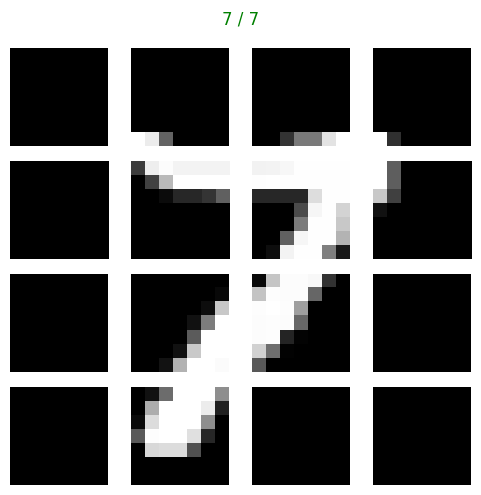

In [34]:
attn_imgs, attn_labels = next(iter(attn_dm.val_dataloader()))
preds = model.predict(attn_imgs)

ix = random.randint(0, dm.batch_size)
fig = plt.figure(figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax = plt.subplot(4, 4, i*4 + j + 1)
        ax.imshow(attn_imgs[ix,i*4 + j].view(7, 7), cmap="gray")
        ax.axis('off')
fig.suptitle(f'{attn_labels[ix]} / {preds[ix].item()}', color="green" if attn_labels[ix] == preds[ix].item() else "red")
plt.tight_layout()
plt.show()